In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import pandas as pd
pd.options.mode.chained_assignment = None

# Initial EDA
Initial eda and data preprocessing

In [2]:
df = pd.read_feather('../data/input/sched_id429650_pitcher669302')
joints = pd.read_csv('../pitch_path/files/joint_ids.csv')


In [3]:
df.head()

,sched_id,joint_type_id,time,x,y,z,astros_pitch_id,pitcher_id,bats,throws
0,429650,1,-1.995,1.3940,60.263401,1.3348,17,669302,L,R
1,429650,1,-1.992,1.3942,60.267899,1.3326,17,669302,L,R
2,429650,1,-1.989,1.3942,60.270199,1.3308,17,669302,L,R
3,429650,1,-1.985,1.3932,60.271900,1.3282,17,669302,L,R
4,429650,1,-1.982,1.3938,60.271801,1.3262,17,669302,L,R


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1382528 entries, 0 to 1382527
Data columns (total 10 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   sched_id         1382528 non-null  int32  
 1   joint_type_id    1382528 non-null  uint8  
 2   time             1382528 non-null  float64
 3   x                1382528 non-null  float32
 4   y                1382528 non-null  float32
 5   z                1382528 non-null  float32
 6   astros_pitch_id  1382528 non-null  int64  
 7   pitcher_id       1382528 non-null  int64  
 8   bats             1382528 non-null  object 
 9   throws           1382528 non-null  object 
dtypes: float32(3), float64(1), int32(1), int64(2), object(2), uint8(1)
memory usage: 75.2+ MB


In [5]:
df[['time', 'x', 'y', 'z']].describe()

,time,x,y,z
count,1.382528e+06,1.382528e+06,1.382528e+06,1.382528e+06
mean,-5.009836e-01,4.129557e-01,5.765936e+01,4.458324e+00
std,8.660648e-01,8.047006e-01,2.620223e+00,1.689636e+00
min,-2.014000e+00,-3.931200e+00,4.979400e+01,7.016000e-01
25%,-1.251000e+00,-3.720000e-02,5.489270e+01,3.255200e+00
50%,-5.010000e-01,3.275000e-01,5.901640e+01,4.594600e+00
75%,2.490000e-01,8.336000e-01,5.996220e+01,5.683200e+00
max,1.015000e+00,4.552600e+00,6.129660e+01,8.133000e+00


In [6]:
joints.head()

,joint_type_id,joint_type,hawkeye
0,1,left ankle,lAnkle
1,2,left ear,lEar
2,3,left elbow,lElbow
3,4,left eye,lEye
4,5,left hip,lHip


In [7]:
df_with_joints = pd.merge(df, joints, how='inner', on='joint_type_id')

In [8]:
df_with_joints.head()

,sched_id,joint_type_id,time,x,y,z,astros_pitch_id,pitcher_id,bats,throws,joint_type,hawkeye
0,429650,1,-1.995,1.3940,60.263401,1.3348,17,669302,L,R,left ankle,lAnkle
1,429650,1,-1.992,1.3942,60.267899,1.3326,17,669302,L,R,left ankle,lAnkle
2,429650,1,-1.989,1.3942,60.270199,1.3308,17,669302,L,R,left ankle,lAnkle
3,429650,1,-1.985,1.3932,60.271900,1.3282,17,669302,L,R,left ankle,lAnkle
4,429650,1,-1.982,1.3938,60.271801,1.3262,17,669302,L,R,left ankle,lAnkle


In [9]:
all_handedness = ['l', 'r']
handedness = df_with_joints.throws.unique()[0].lower()
front_leg = [x for x in all_handedness if x != handedness][0]
joints_to_filter_to = [f"{handedness}Shoulder", f"{handedness}Elbow", f"{handedness}Wrist", f"{front_leg}Knee"]

In [10]:
df_with_joints_fil = df_with_joints[df_with_joints["hawkeye"].isin(joints_to_filter_to)].reset_index()

In [11]:
df_with_joints_fil.head()

,index,sched_id,joint_type_id,time,x,y,z,astros_pitch_id,pitcher_id,bats,throws,joint_type,hawkeye
0,4500,429650,6,-1.995,0.8863,59.942902,2.7927,17,669302,L,R,left knee,lKnee
1,4501,429650,6,-1.992,0.8920,59.949699,2.7933,17,669302,L,R,left knee,lKnee
2,4502,429650,6,-1.989,0.8973,59.953602,2.7937,17,669302,L,R,left knee,lKnee
3,4503,429650,6,-1.985,0.9029,59.959301,2.7943,17,669302,L,R,left knee,lKnee
4,4504,429650,6,-1.982,0.9070,59.964001,2.7948,17,669302,L,R,left knee,lKnee


# Plotting
Some visualizations to assist with EDA. 3D plots that are interactive, as well as plots of axis by time for arm joints and knee.

In [12]:
def plot_pitch(pitch_df):
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(projection='3d')

    # get the indices of each joint type where each is closest to 0 (release time)
    # TODO: order by body part, not by z value
    release = pitch_df.groupby('hawkeye', as_index=False).agg({'time': lambda x: x.abs().min()})
    release_df = pd.merge(pitch_df, release, on=["hawkeye", "time"], how="inner").sort_values(by=['z'])
    ax.scatter(release_df.x, release_df.y, release_df.z, label='Release', s=50, edgecolors="black", alpha=1)

    # create connected plot to show shoulder -> elbow -> wrist in space
    plt.plot(release_df.x, release_df.y, release_df.z, linestyle='dashed', marker='s')

    # for each joint, plot the path in 3d
    for grp_name, grp_idx in pitch_df.groupby('hawkeye').groups.items():
        y = pitch_df.loc[grp_idx,'y']
        x = pitch_df.loc[grp_idx,'x']
        z = pitch_df.loc[grp_idx,'z']
        ax.scatter(x, y, z, label=grp_name, s=5, alpha=0.5)
        ax.set_xlabel('x-axis') 
        ax.set_ylabel('y-axis') 
        ax.set_zlabel('z-axis') 

    ax.legend(bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)
    plt.show()

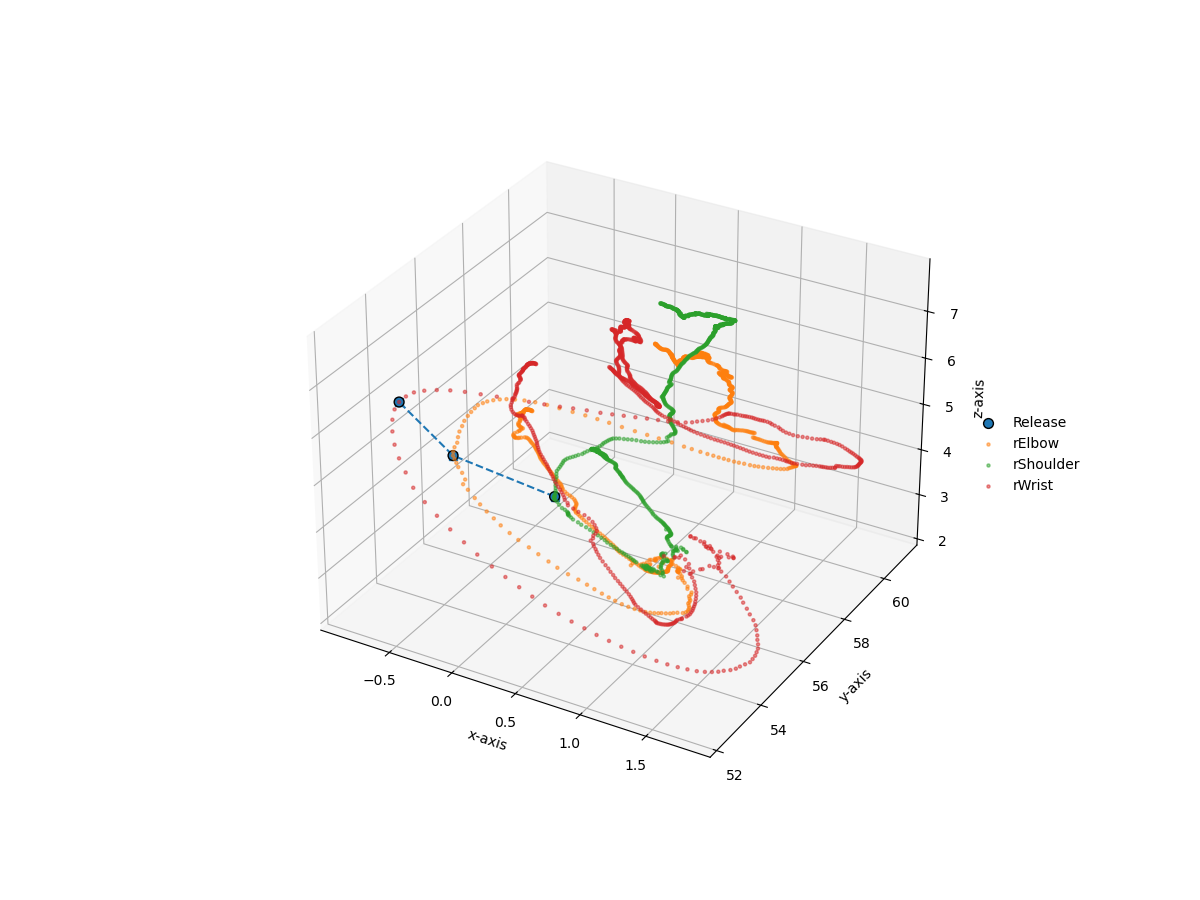

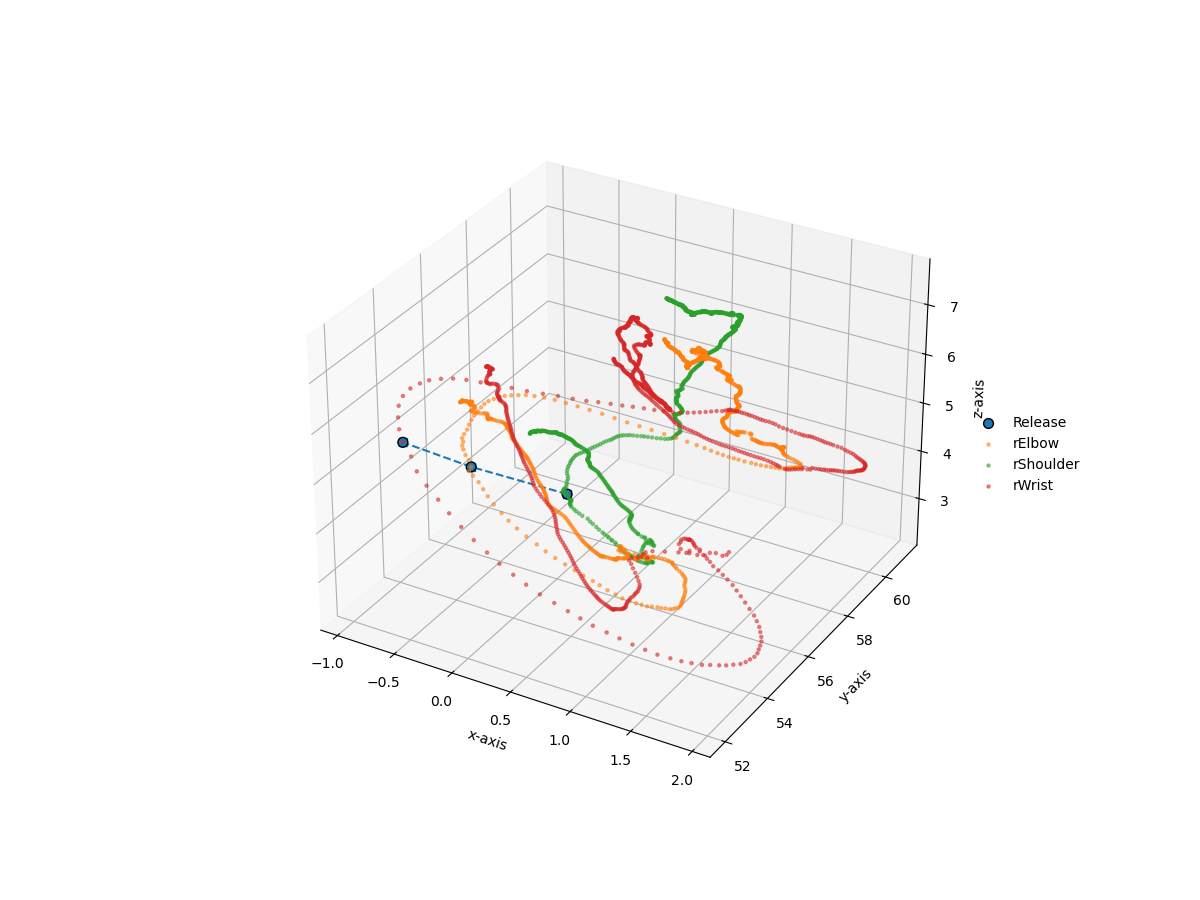

In [13]:
%matplotlib widget 
df_arm = df_with_joints_fil[~df_with_joints_fil['hawkeye'].str.contains('Knee')]
for pitch_id in df_arm.astros_pitch_id.unique()[:2]:
    #drop knee column for plotting
    df_fil =  df_arm[df_arm['astros_pitch_id'] == pitch_id]
    plot_pitch(df_fil)


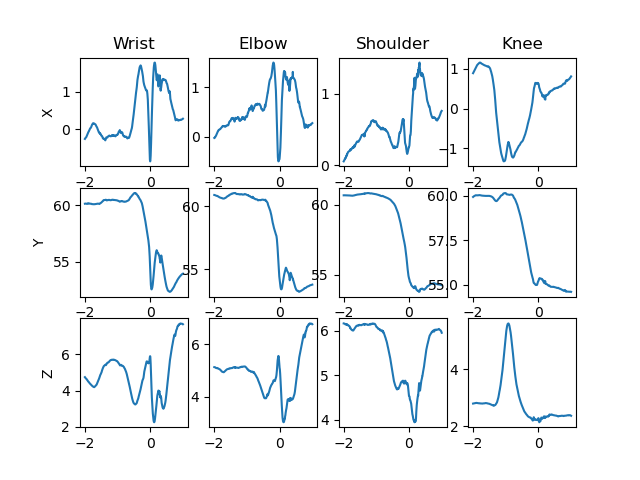

In [14]:

figure, axis = plt.subplots(3, 4) 

wrist = df_with_joints_fil[(df_with_joints_fil['astros_pitch_id'] == 17) & (df_with_joints_fil['hawkeye'] == 'rWrist')]
elbow = df_with_joints_fil[(df_with_joints_fil['astros_pitch_id'] == 17) & (df_with_joints_fil['hawkeye'] == 'rElbow')]
shoulder = df_with_joints_fil[(df_with_joints_fil['astros_pitch_id'] == 17) & (df_with_joints_fil['hawkeye'] == 'rShoulder')]
knee = df_with_joints_fil[(df_with_joints_fil['astros_pitch_id'] == 17) & (df_with_joints_fil['hawkeye'] == 'lKnee')]


# set titles
axis[0, 0].set_title("Wrist") 
axis[0, 1].set_title("Elbow") 
axis[0, 2].set_title("Shoulder") 
axis[0, 3].set_title("Knee") 


axis[0,0].set_ylabel('X')
axis[1,0].set_ylabel('Y')
axis[2,0].set_ylabel('Z')

# plot X
axis[0, 0].plot(wrist.time, wrist.x) 
axis[0, 1].plot(elbow.time, elbow.x) 
axis[0, 2].plot(shoulder.time, shoulder.x) 
axis[0, 3].plot(knee.time, knee.x) 


# plot Y
axis[1, 0].plot(wrist.time, wrist.y) 
axis[1, 1].plot(elbow.time, elbow.y) 
axis[1, 2].plot(shoulder.time, shoulder.y) 
axis[1, 3].plot(knee.time, knee.y) 


# plot Z
axis[2, 0].plot(wrist.time, wrist.z) 
axis[2, 1].plot(elbow.time, elbow.z) 
axis[2, 2].plot(shoulder.time, shoulder.z) 
axis[2, 3].plot(knee.time, knee.z) 

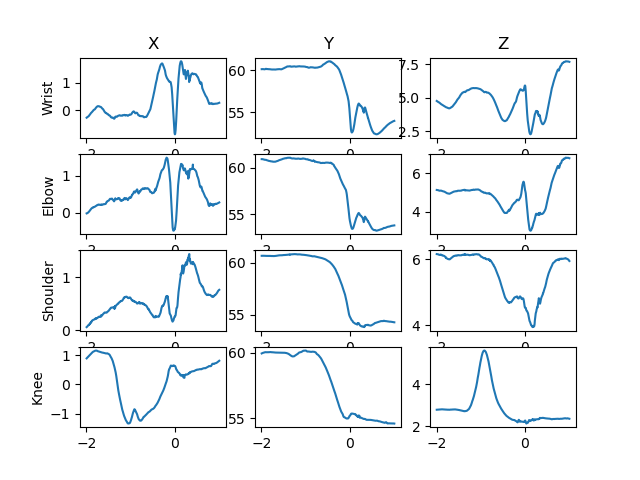

In [15]:

figure, axis = plt.subplots(4, 3) 

wrist = df_with_joints_fil[(df_with_joints_fil['astros_pitch_id'] == 17) & (df_with_joints_fil['hawkeye'] == 'rWrist')]
elbow = df_with_joints_fil[(df_with_joints_fil['astros_pitch_id'] == 17) & (df_with_joints_fil['hawkeye'] == 'rElbow')]
shoulder = df_with_joints_fil[(df_with_joints_fil['astros_pitch_id'] == 17) & (df_with_joints_fil['hawkeye'] == 'rShoulder')]
knee = df_with_joints_fil[(df_with_joints_fil['astros_pitch_id'] == 17) & (df_with_joints_fil['hawkeye'] == 'lKnee')]


# set titles
axis[0, 0].set_title("X") 
axis[0, 1].set_title("Y") 
axis[0, 2].set_title("Z") 

axis[0,0].set_ylabel('Wrist')
axis[1,0].set_ylabel('Elbow')
axis[2,0].set_ylabel('Shoulder')
axis[3,0].set_ylabel('Knee')


# plot Wrist
axis[0, 0].plot(wrist.time, wrist.x) 
axis[0, 1].plot(wrist.time, wrist.y) 
axis[0, 2].plot(wrist.time, wrist.z) 

# plot Elbow
axis[1, 0].plot(elbow.time, elbow.x) 
axis[1, 1].plot(elbow.time, elbow.y) 
axis[1, 2].plot(elbow.time, elbow.z) 

# plot Shoulder
axis[2, 0].plot(shoulder.time, shoulder.x) 
axis[2, 1].plot(shoulder.time, shoulder.y) 
axis[2, 2].plot(shoulder.time, shoulder.z) 

# plot Knee
axis[3, 0].plot(knee.time, knee.x) 
axis[3, 1].plot(knee.time, knee.y) 
axis[3, 2].plot(knee.time, knee.z) 

# Leg Lift
EDA of leg lift data to see if we can determine when wind up starts so that we can subset our data for features.

In [16]:
knee_df = df_with_joints_fil[(df_with_joints_fil['astros_pitch_id'] == 17) & (df_with_joints_fil['hawkeye'] == 'lKnee')]

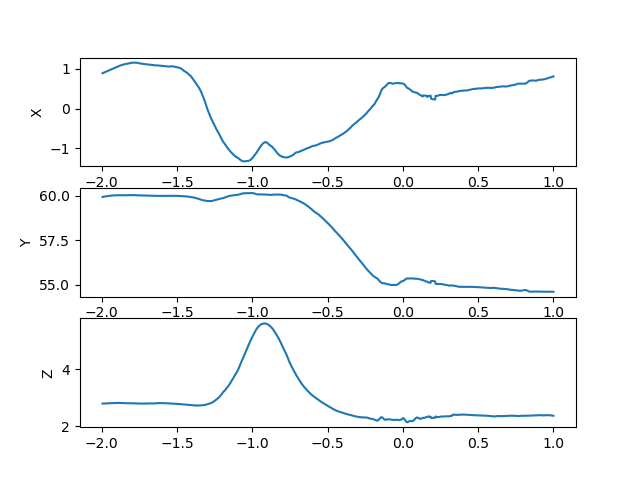

In [17]:
figure, axis = plt.subplots(3, 1) 
axis[0].plot(knee_df.time, knee_df.x) 
axis[0].set_ylabel('X')
axis[1].plot(knee_df.time, knee_df.y) 
axis[1].set_ylabel('Y')
axis[2].plot(knee_df.time, knee_df.z) 
axis[2].set_ylabel('Z');

In [18]:
 min_time = df.groupby('astros_pitch_id', as_index=False).agg({'time': lambda x: x.abs().min()})


In [19]:
rolling_increase = lambda x, window: x['z'].diff().gt(0).rolling(window).sum().eq(window)

In [20]:
w = 30
increasing_df = df_with_joints_fil.groupby('astros_pitch_id').apply(lambda x: rolling_increase(x, w), include_groups=False)

In [21]:
df_test = df_with_joints_fil[(df_with_joints_fil.astros_pitch_id == 17) & (df_with_joints_fil.hawkeye == 'lKnee')]
df_test2 = df_test.sort_values(by=['time']).reset_index()
df_test2['increasing'] = df_test2['z'].diff().gt(0).rolling(30).sum().eq(30)
leg_lift_time = df_test2[df_test2['increasing']].time.min()
leg_lift_time

-1.2489999999999999

In [22]:
def get_leg_lift_time(df: pd.DataFrame, col:str = 'z', window:int = 30):
    df_sorted = df.sort_values(by=['time']).reset_index()
    df_sorted['increasing'] = df_sorted[col].diff().gt(0).rolling(window).sum().eq(window)
    leg_lift_time = df_sorted[df_sorted['increasing']].time.min()
    return leg_lift_time


In [23]:
def set_leg_lift_time(df: pd.DataFrame):
    astros_pitch_id = df.astros_pitch_id.unique()
    leg_lift_time = []
    for pitch_id in astros_pitch_id:
        pitch_df = df[(df.astros_pitch_id == pitch_id) & (df.hawkeye == 'lKnee')]
        leg_lift_time.append(get_leg_lift_time(pitch_df))
    
    ll = pd.DataFrame({'astros_pitch_id': astros_pitch_id, 'time': leg_lift_time})
    ll['start'] = 1

    pitches_w_start = pd.merge(df, ll, how='left', on=['astros_pitch_id', 'time']).fillna(0)

    return pitches_w_start


In [24]:
pitches_w_start = set_leg_lift_time(df_with_joints_fil)

In [25]:
pitches_w_start[pitches_w_start.start == 1].head(20)

,index,sched_id,joint_type_id,time,x,y,z,astros_pitch_id,pitcher_id,bats,throws,joint_type,hawkeye,start
224,4724,429650,6,-1.249,-0.4390,59.757801,2.8943,17,669302,L,R,left knee,lKnee,1.0
1124,9224,429650,13,-1.249,0.3768,60.980000,5.1007,17,669302,L,R,right elbow,rElbow,1.0
2024,12824,429650,17,-1.249,0.5306,60.855900,6.1299,17,669302,L,R,right shoulder,rShoulder,1.0
2924,13724,429650,18,-1.249,-0.1723,60.455898,5.6102,17,669302,L,R,right wrist,rWrist,1.0
3830,19130,429650,6,-1.246,-0.3185,59.742599,2.8789,18,669302,L,R,left knee,lKnee,1.0
4730,23630,429650,13,-1.246,0.3446,60.962002,5.1495,18,669302,L,R,right elbow,rElbow,1.0
5630,27230,429650,17,-1.246,0.6484,60.780899,6.1641,18,669302,L,R,right shoulder,rShoulder,1.0
6530,28130,429650,18,-1.246,-0.1722,60.363400,5.5699,18,669302,L,R,right wrist,rWrist,1.0
7421,33526,429650,6,-1.265,-0.2141,59.706200,2.8518,19,669302,L,R,left knee,lKnee,1.0
8322,38031,429650,13,-1.265,0.4943,61.031101,5.1538,19,669302,L,R,right elbow,rElbow,1.0


In [26]:
def plot_leg_lift(df, leg_lift_time, pitch_no, window):

    fig, axis = plt.subplots(4, 3) 
    st = fig.suptitle(f"Window: {window}\nTime: {round(leg_lift_time, 3)}\n", size=8)

    wrist = df[df['hawkeye'] == 'rWrist']
    elbow = df[df['hawkeye'] == 'rElbow']
    shoulder = df[df['hawkeye'] == 'rShoulder']
    knee = df[df['hawkeye'] == 'lKnee']


    # set titles
    axis[0, 0].set_title("X") 
    axis[0, 1].set_title("Y") 
    axis[0, 2].set_title("Z") 

    axis[0,0].set_ylabel('Wrist')
    axis[1,0].set_ylabel('Elbow')
    axis[2,0].set_ylabel('Shoulder')
    axis[3,0].set_ylabel('Knee')


    # plot Wrist
    axis[0, 0].plot(wrist.time, wrist.x) 
    axis[0, 1].plot(wrist.time, wrist.y) 
    axis[0, 2].plot(wrist.time, wrist.z) 
    axis[0, 0].axvline(leg_lift_time, color='red')
    axis[0, 1].axvline(leg_lift_time, color='red')
    axis[0, 2].axvline(leg_lift_time, color='red')

    # plot Elbow
    axis[1, 0].plot(elbow.time, elbow.x) 
    axis[1, 1].plot(elbow.time, elbow.y) 
    axis[1, 2].plot(elbow.time, elbow.z) 
    axis[1, 0].axvline(leg_lift_time, color='red')
    axis[1, 1].axvline(leg_lift_time, color='red')
    axis[1, 2].axvline(leg_lift_time, color='red')

    # plot Shoulder
    axis[2, 0].plot(shoulder.time, shoulder.x) 
    axis[2, 1].plot(shoulder.time, shoulder.y) 
    axis[2, 2].plot(shoulder.time, shoulder.z) 
    axis[2, 0].axvline(leg_lift_time, color='red')
    axis[2, 1].axvline(leg_lift_time, color='red')
    axis[2, 2].axvline(leg_lift_time, color='red')

    # plot Knee
    axis[3, 0].plot(knee.time, knee.x) 
    axis[3, 1].plot(knee.time, knee.y) 
    axis[3, 2].plot(knee.time, knee.z) 
    axis[3, 0].axvline(leg_lift_time, color='red')
    axis[3, 1].axvline(leg_lift_time, color='red')
    axis[3, 2].axvline(leg_lift_time, color='red')


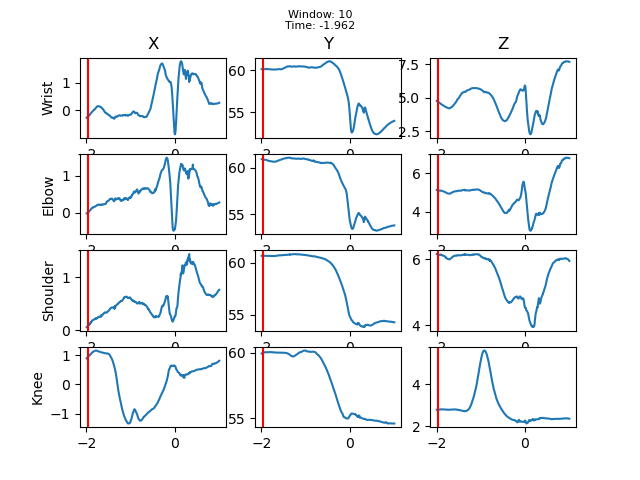

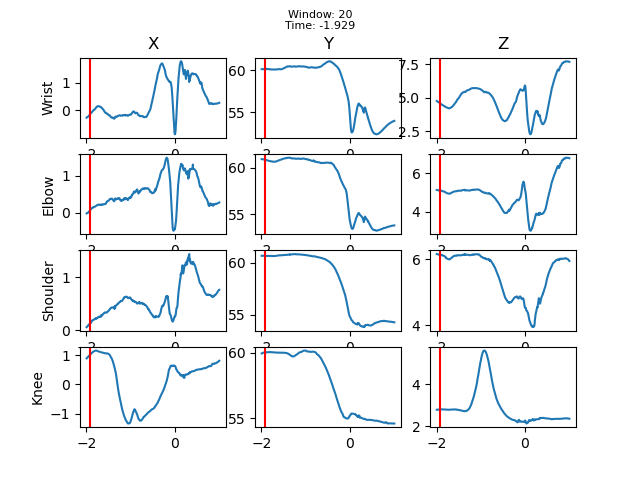

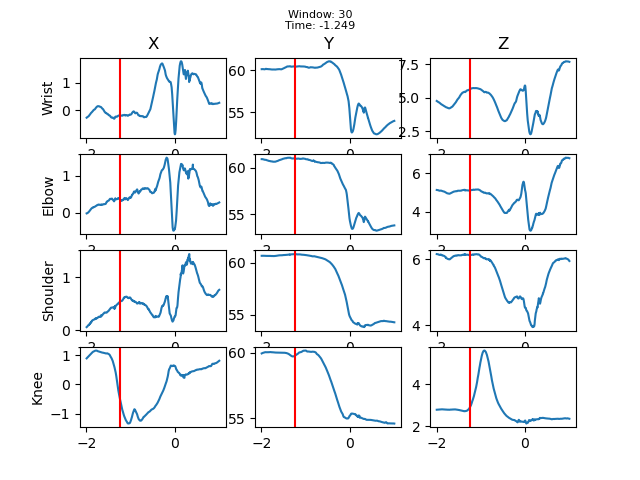

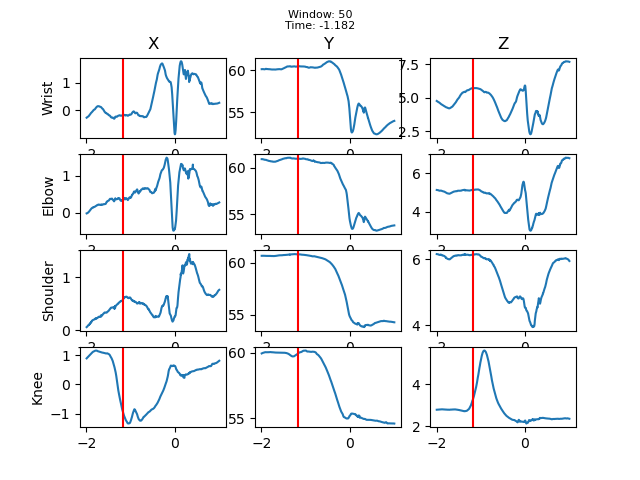

In [27]:
windows = [10, 20, 30, 50]
pitch = 17
for w in windows:
    pitch_df = df_with_joints_fil[df_with_joints_fil['astros_pitch_id'] == pitch]

    ll_time = get_leg_lift_time(pitch_df[pitch_df['hawkeye'] == 'lKnee'], window=w)
    plot_leg_lift(pitch_df, ll_time, pitch, w)
    

## Plot pitch from each processed df

In [28]:
feature_dfs_list = []
feature_dfs_list.append(pd.read_feather('../data/output/pitcher_features/sched_id429650_pitcher669302').head(1))
feature_dfs_list.append(pd.read_feather('../data/output/pitcher_features/sched_id429650_pitcher680689').head(1))
feature_dfs_list.append(pd.read_feather('../data/output/pitcher_features/sched_id429722_pitcher554430').head(1))
feature_dfs_list.append(pd.read_feather('../data/output/pitcher_features/sched_id429722_pitcher642547').head(1))
feature_dfs_list.append(pd.read_feather('../data/output/pitcher_features/sched_id429804_pitcher554430').head(1))
feature_dfs_list.append(pd.read_feather('../data/output/pitcher_features/sched_id429804_pitcher641712').head(1))
feature_dfs_list.append(pd.read_feather('../data/output/pitcher_features/sched_id430322_pitcher543243').head(1))
feature_dfs_list.append(pd.read_feather('../data/output/pitcher_features/sched_id430322_pitcher669302').head(1))
feautre_df = pd.concat(feature_dfs_list).reset_index().drop(columns=['index'])

In [ ]:
plt.le

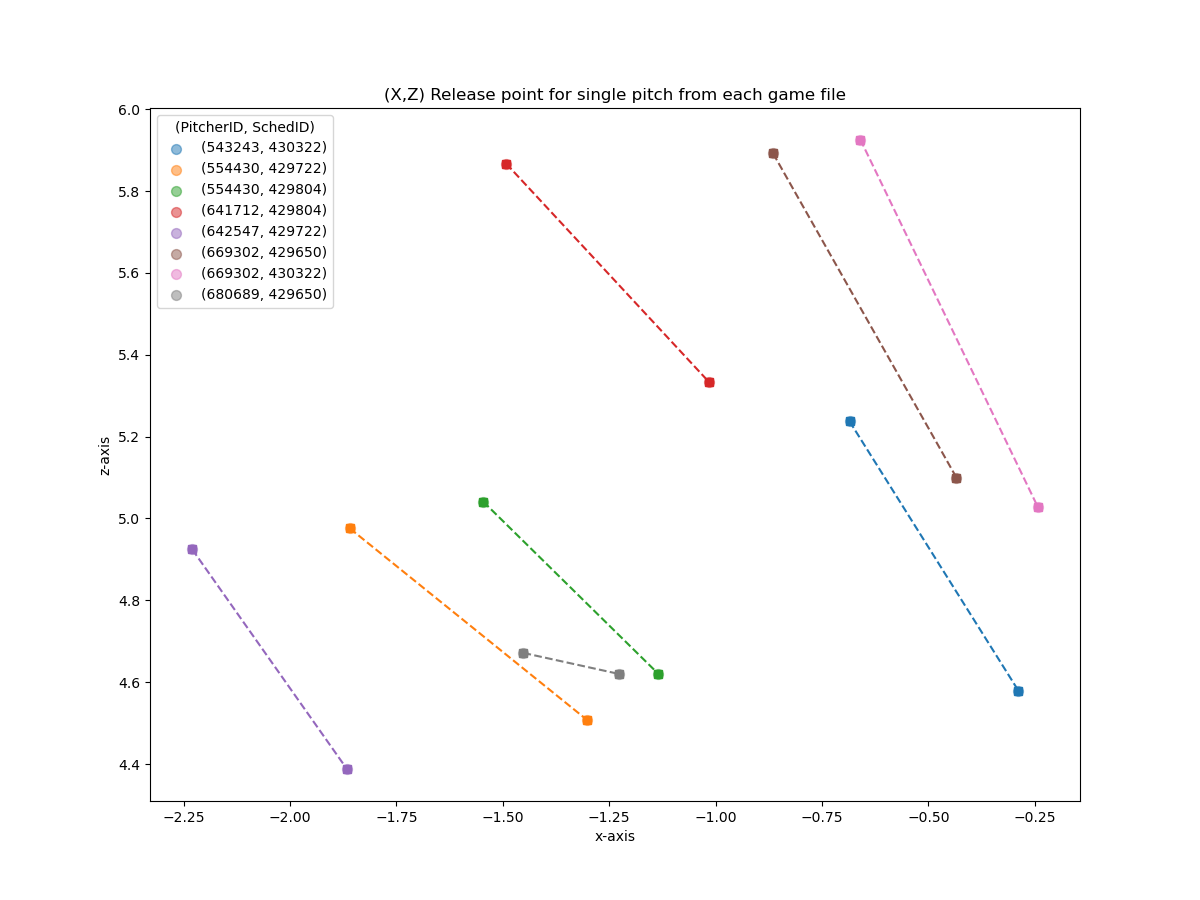

In [42]:
fig = plt.figure(figsize=(12, 9))

for grp_name, grp_idx in feautre_df.groupby(['pitcher_id', 'sched_id']).groups.items():
    #y = pd.concat([feautre_df.loc[grp_idx,'wrist_y_release'], feautre_df.loc[grp_idx,'elbow_y_release'], feautre_df.loc[grp_idx,'shoulder_y_release']])
    x = pd.concat([feautre_df.loc[grp_idx,'wrist_x_release'], feautre_df.loc[grp_idx,'elbow_x_release']])
    z = pd.concat([feautre_df.loc[grp_idx,'wrist_z_release'], feautre_df.loc[grp_idx,'elbow_z_release']])
    plt.scatter(x, z, label=grp_name, s=50, alpha=0.5)
    plt.xlabel('x-axis') 
    plt.ylabel('z-axis') 
    #ax.set_zlabel('z-axis') 
    plt.plot(x, z, linestyle='dashed', marker='s')
plt.legend(title="(PitcherID, SchedID)")
plt.title("(X,Z) Release point for single pitch from each game file")
plt.show()
fig.savefig("../img/single_pitch_each_game_release.png")